## QPO Detection using ABC

We're going to use ABC to detect QPOs in better ways that with dumb frequentist statistics.



In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from BayesPSD import lightcurve, powerspectrum

In [129]:
def qpo(x, loggamma, logamplitude, x0 ):
    gamma = np.exp(loggamma)
    amplitude = np.exp(logamplitude)

    alpha = 0.5*amplitude*gamma/np.pi
    y = alpha/((x - x0)**2 + (0.5*gamma)**2)
    return y

def powerlaw(x, index, logamplitude):
    return np.exp(-np.log(x)*index + logamplitude)

def fake_data(model, m):
    noise = np.random.chisquare(2*m, size=model.shape[0])/(2.0*m)
    return noise*model


In [190]:
## frequencies
freq = np.arange(1.0, 1000., 1.0)

loggamma = -2
logqpoamp = 4
x0 = 40.0

index = 2.0
logplamp = 8

#m = powerlaw(freq, index, logplamp) + qpo(freq, loggamma, logqpoamp, x0) + 2.0
m =  qpo(freq, loggamma, logqpoamp, x0) + 2.0

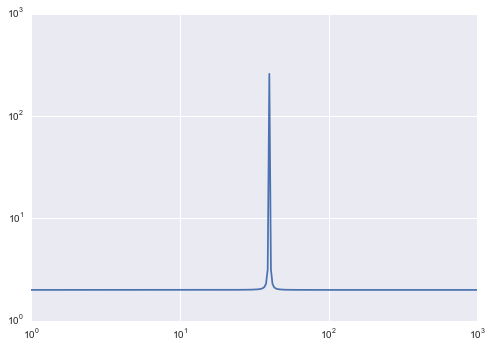

In [191]:
plt.loglog(freq, m)

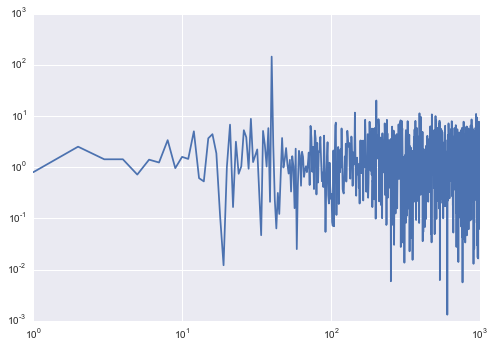

In [193]:
mdata = fake_data(m, 1)
plt.loglog(freq, mdata)

In [165]:
from BayesPSD import posterior
import scipy.optimize

#plnoise = lambda x, index, lognorm, noise: powerlaw(x, index, lognorm) + noise

def fit_psd(freq, power):
    ps = powerspectrum.PowerSpectrum()
    ps.freq = freq
    ps.ps = power
    ps.df = ps.freq[1]-ps.freq[0]
    ps.nphot = ps.ps[0]

    lpost = posterior.PerPosterior(ps,plnoise)
    res = scipy.optimize.minimize(lpost.loglikelihood, [1, 8, 2.0], method="BFGS", args=(True))
    print(res)
    print(lpost.loglikelihood(res.x))
    return res.x

In [166]:
popt = fit_psd(freq, mdata)

   status: 0
  success: True
     njev: 40
     nfev: 200
 hess_inv: array([[ 0.0168367 ,  0.04427993,  0.00185541],
       [ 0.04427993,  0.14728339,  0.00285899],
       [ 0.00185541,  0.00285899,  0.00499126]])
      fun: 1802.1216585210173
        x: array([ 1.97849016,  8.10760416,  1.96789357])
  message: 'Optimization terminated successfully.'
      jac: array([ 0.,  0.,  0.])
      nit: 25
1802.12165852


In [167]:
mfit = powerlaw(freq, *popt[:2]) + popt[-1]

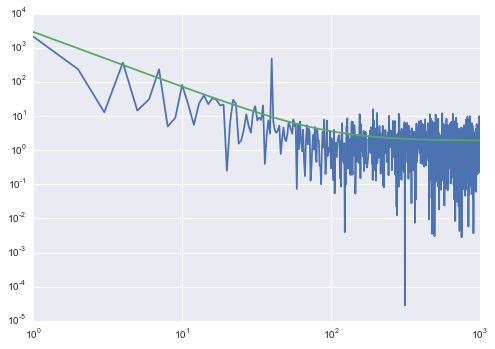

In [127]:
plt.loglog(freq, mdata)
plt.loglog(freq, mfit)


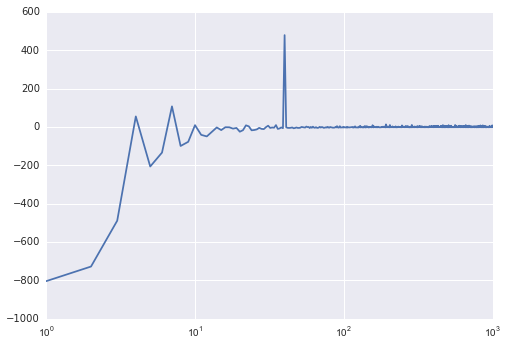

In [128]:
plt.plot(freq, mdata-mfit)
plt.xscale("log")

In [212]:
def from_prior():
    n = np.random.choice([0,1], size=1,replace=True, p=[0.5, 0.5])
    p = []
    pl_amp = np.exp(np.random.uniform(-6, 6))
    pl_index = np.random.uniform(1, 4)
    noise = np.random.uniform(1,3)
    p.extend([pl_index, pl_amp, noise])
    if n > 0:
        f0 = np.exp(np.random.uniform(low=np.log(10), high = np.log(1000.0)))
        loggamma = np.log(f0/np.random.uniform(2, 100))
        logamp = np.random.uniform(-6, 6)
        p.extend([loggamma, logamp, f0])
    return n, p

In [213]:
## fit real data
#popt = fit_psd(freq, mdata)
#mfit = powerlaw(freq, *popt[:2]) + popt[-1]
#maxpower = np.max(mdata[10:]/mfit[10:])
maxpower = np.max(mdata)

def model_data_distance(freq, model, maxpower, m):
    ## fit fake data
    fdata = fake_data(model,m)
    #fx = fit_psd(freq, fdata)
    #fmfit = powerlaw(freq, *fx[:2]) + fx[-1]
    #fmaxpower = np.max(fdata[10:]/fmfit[10:])
    fmaxpower = np.max(fdata)
    
    dp = np.abs(maxpower - fmaxpower)
    return dp
    

In [228]:
dp_dist = []
nsim = 5000
new_pars = []
for i in xrange(nsim):
    n,p = from_prior()
    old_model = powerlaw(freq, *p[:2]) + p[2]
    if len(p) > 3:
        model = qpo(freq, *p[3:])
    
    dp = model_data_distance(freq, model, maxpower, 1)
    dp_dist.append(dp)
    if dp < 5:
        new_pars.append(p)

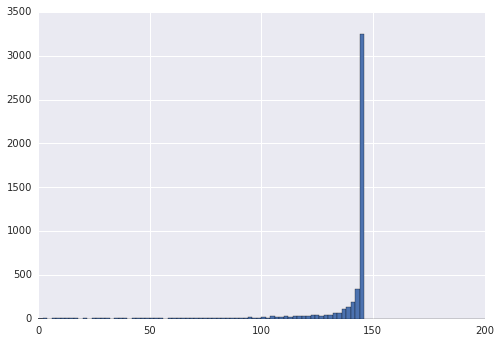

In [229]:
plt.hist(dp_dist, bins=100, range=[0,200]);

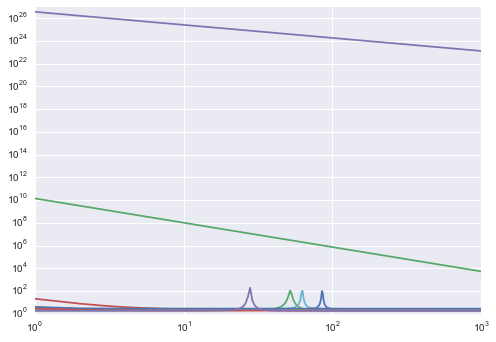

In [230]:
for p in new_pars:
    model = powerlaw(freq, *p[:2]) + p[2]
    if len(p) > 3:
        model = qpo(freq, *p[3:]) + p[2]
    plt.loglog(freq, model)